## Tarea 2

### Prescriptive analytics: Heuristics for Decision-Making

### Wilmar Calderón

#### 201630701

#### Descripción del ejercicio:

Este documento brinda una solución heurísitca constructiva para el caso del ruteo de arcos capacitado (CARP). Este documento busca dar una solución incial para las instancias de Golden et at. (1983) para encontrar una primera solución factible al problema de ruteo usando la implementación propuesta por (Santos, 2009).

Considerando esto, la implementación se plantea en cuatro secciones:
1. Importación de librerías requeridas y previsualización del problema a resolver.
2. Definición de la la solución constructiva
3. Lectura de un archivo para obtener los detalles de la red contenida eenna instancia
4. Ejecución de las 23 instancias de Golden et at. (1983)

#### Referencias:
Santos, L., Coutinho-Rodrigues, J., & Current, J. R. (2009). An improved heuristic for the capacitated arc routing problem. Computers & Operations Research, 36(9), 2632–2637. https://doi.org/10.1016/j.cor.2008.11.005

## 1. Importación de librerías requeridas

In [45]:
# Importación de librerías utilizadas

import numpy as np #manejo de listas, arreglos y matrices
import re #regular expression: útil para leer facilmente las instancias y obtener la información rápidamente
import os #requerido para la lectura de los archivos .dat de las instancias 
import matplotlib.pyplot as plt #grafica
import networkx as nx #módulo para evaluar grafos, redes, rutas más cortas.
import time #módulo para evalaur el tiempo de ejecución de las soluciones
import random

### 1.1 Previsualización del problema a resolver

Esta sección busca hacer un gráfico inicial de la primera instancia de Golden et at. (1983) para identificar de forma visual el tipo de redes a analizar, así como realizar algunas pruebas y ajustes inciiales, como para las expresiones regulares, que se usarán para la lectura de la información de todas las instancias.

In [46]:
## PRIMER EJEMPLO: LEE EL ARCHIVO GDB PARA ILUSTRAR EL CASO DE ESTUDIO: CARP EN REDES.
###     En esta sección se ajustaron los detalles de la REGEX para poder leer los detalles de todas las instancias de Golden

# Lee el archivo. En la carpeta en dónde se ejecute el notebook debe estar el archivo
# Cambiar el nombre de la instancia para cambiar el archivo de lectura (pero el archivo de la instancia debe estar en la carpeta)
file_path = os.path.join(os.getcwd(), "gdb1.dat")
with open(file_path, "r") as file:
    texto = file.read()

# Expresión regular para extraer los atributos de los arcos
arcos = {
    (int(n1), int(n2)): [int(c), int(d)]
    for n1, n2, c, d in re.findall(r"\(\s*(\d+),\s*(\d+)\)\s+coste\s+(\d+)\s+demanda\s+(\d+)", texto)
}

# Expresión regular para capturar el número después de "DEPOSITO :"
match = re.search(r"DEPOSITO\s*:\s*(\d+)", texto)
depot=int(match.groups()[0])

# Expresión regular para capturar el número después de "VEHICULOS :"
match1 = re.search(r"VEHICULOS\s*:\s*(\d+)", texto)
veh=int(match1.groups()[0])

# Expresión regular para capturar el número después de "CAPACIDAD :"
match2 = re.search(r"CAPACIDAD\s*:\s*(\d+)", texto)
veh_cap=int(match2.groups()[0])

#Imprime los parámetros 
print("Nodo del Depósito: ", depot)
print("Número de Vehículos: ",veh)
print("Capacidad de cada Vehículo: ",veh_cap)

Nodo del Depósito:  1
Número de Vehículos:  5
Capacidad de cada Vehículo:  5


In [47]:
# Creación del grafo de ejemplo
G = nx.Graph()

# Agregar nodos y aristas con atributos (basado en el diccionario de atributo de arcos leído del archivo .dat)
for (n1, n2), (coste, demanda) in arcos.items():
    G.add_edge(n1, n2, weight=coste, demanda=demanda)


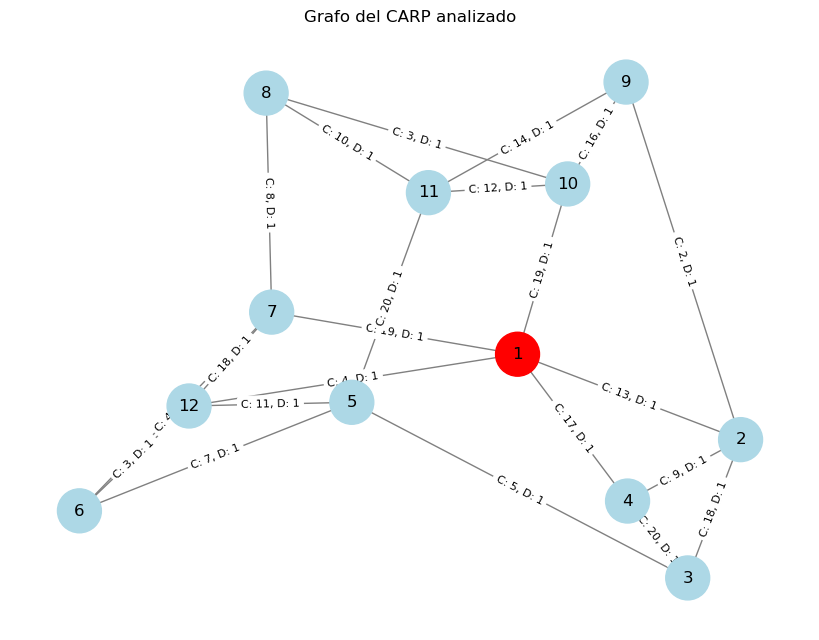

In [48]:
# Dibujo del Grafo. (como no hay coordenadas de distancia, graficado con la forma de nx.spring_layout)

seed=8 #fija la semilla aleatoria para cualquier cambio de vista (por ejemplo random)
pos = nx.spring_layout(G)  # Carga el gráfico basado en el grafo creado

#Creación de las notas de los arcos
edge_labels = {(n1, n2): f"C: {coste}, D: {demanda}" for (n1, n2), (coste, demanda) in arcos.items()}

plt.figure(figsize=(8, 6))
#Definición de los colores (separa el depósito para visualización)
node_colors = ["red" if node == depot else "lightblue" for node in G.nodes()]
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1000, edge_color='gray', font_size=12)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Grafo del CARP analizado")
plt.show()

## 2. Definición de Solución constructiva.

La solución propuesta sigue el pseudo-código propuesto por Santos (2009) y busca generar un filtro de forma de elipse para poder asignar arcos sucesivamente a una ruta se se cumplen determinadas condiciones de costo. A continuación el pseudo-código implementado.

$$
\begin{array}{l}
CS_{best} \gets +\infty \\
iter \gets 1 \\
\textbf{while } (iter \leq nmit) \textbf{ and } (CS_{best} > LB) \textbf{ do } \\
\quad S_{cur} \gets v_0 \\
\quad rvc \gets w \\
\quad \textbf{for } i = 1 \textbf{ to } ned \textbf{ do } \\
\quad\quad \textbf{if } (rvc > \alpha \times td/ned) \textbf{ then } \\
\quad\quad\quad \text{Determinar } F \\
\quad\quad \textbf{else} \\
\quad\quad\quad \text{Determinar } F \text{ satisfaciendo ecuación (1)} \\
\quad\quad \textbf{end if} \\
\quad\quad \textbf{if } (F = \emptyset) \textbf{ then } \\
\quad\quad\quad S_{cur} \gets S_{cur} \cup \{v_0\} \quad \text{// El vehículo regresa al depósito} \\
\quad\quad\quad rvc \gets w \\
\quad\quad \textbf{else} \\
\quad\quad\quad \text{Seleccionar } [v_p, v_j] \text{ aleatoriamente de } F \\
\quad\quad\quad S_{cur} \gets S_{cur} \cup \{[v_p, v_j]\} \cup \{v_j\} \\
\quad\quad\quad rvc \gets rvc - q_{pj} \\
\quad\quad \textbf{end if} \\
\quad \textbf{end for} \\
\quad \textbf{if } (CS_{cur} < CS_{best}) \textbf{ then } \\
\quad\quad CS_{best} \gets CS_{cur} \quad \text{// Si la solución actual es mejor} \\
\quad \textbf{end if} \\
\quad iter \gets iter + 1 \\
\textbf{end while} \\
\end{array}
$$

In [49]:

# Regla de la Elipse, según definido por (Santos, 2009), busca establecer el arco (p,j) que debe ser atendido después de atender el 
# arco (h,i) si satisfacen la condición (1) determinada por (Santos, 2009)

#Input: G: Grafo
#node_i: el nodo final del último arco asignado
#pending_edges: lista de arcos que no han sido selecccionados
#tc/ned: ratio entre el costo total de los arcos (tc) y el número de arcos (ned)
#rvc: Capacidad actual que tiene el vehículo 

#Output: Selected edges= arcos por asignar, costs= costo de asignación del arco (p,j), routes= listado con la ruta (nodo a nodo) necesaria para cubrir el arco (p,j)
def filter_edges_by_ellipse(G, node_i,pending_edges,tc,ned,rvc):
    selected_edges = []
    routes= []
    costs= []
    #Obtener las rutas más cortas desde el depot hasta cada elemento del grafo
    shortest_paths = nx.single_source_dijkstra_path_length(G, depot, weight="weight")
    #Obtener las rutas más cortas desde el nodo_i hasta cada elemento del grafo
    best_nodes=nx.single_source_dijkstra_path_length(G, node_i, weight="weight")
    #Elimina los datos del mismo nodo
    best_nodes.pop(node_i)

    #recorrido de los arcos pendientes por asignación
    for i in pending_edges:
        p=i[0]
        j=i[1]
            #Verificación que el grafo si tenga el arco (p,j) de lo contrario se evalúa otro i
        if G.has_edge(p, j):
            #Ruta más corta desde el nodo_i hasta el nodo p
            SP_vi_vp= best_nodes.get(p, float(1000))
            #costo del nodo (p,j)
            c_pj=G[p][j]['weight']
            #Ruta más corta desde el nodo j hasta el depot
            SP_vj_v0 = shortest_paths.get(j, float(1000))
            #Ruta más corta desde el nodo node_i hasta el depot
            SP_vi_v0 = shortest_paths.get(node_i, float(1000))
            #cálculo del costo de referencia para hacer la regla de la Elipse de (Snatos, 2009)
            reference=SP_vi_vp + c_pj + SP_vj_v0
            #almacena los arcos que cumplan con la condición de (Santos, 2009) y que puedan ser atendidos según la capacidad actual del vehículo
            if (reference <= (tc / ned) + SP_vi_v0) and (rvc-G[p][j]["demanda"]>=0):
                selected_edges.append((p, j))
                routes.append([j,depot])
                costs.append(reference)

    return selected_edges,costs,routes


#Input: G: Grafo
#depot: el nodo del depósito de la instancia
#alpha: Parámetro de la regla de la elipse que determina qué tan rápido se empieza a hacer el filtro de la elipse
#iter: número de iteraciones que se harán para encontrar la mejor asignación por instancia
#veh_cap: Capacidad que tienen los vehículos

#Output: sol: Costo de la mejor solución, pending_edges: lista vacía si se asignaron todos los arcos,
#best_routes[-1]: mejor ruteo encontrado, td: demanda total atendida

def carp_V2(G,depot,alpha,iter,veh_cap):
    #definición de los parámetros del grafo de la instancia
    tc = sum(G[u][v]["weight"] for u, v in G.edges())
    td = sum(G[u][v]["demanda"] for u, v in G.edges())
    ned = len(G.edges())

    #generación de la matriz de adyacencia para identificar: (1) si 2 arcos son adyacentes; (2) costos de esos arcos
    cost_adj=nx.adjacency_matrix(G,nodelist=range(1,len(G.nodes())+1))
    #costos de salida de cada nodo (costos de los arcos) 
    cost_out=cost_adj.todense()

    best_routes=[]
    #valor inicial de la solución para poder identificar mejoras en las iteraciones
    sol=10000

    #Ciclo para ejecutar las iteraciones del algoritmo
    rep=0
    while (rep<iter):
        routes=[]
        c_i=0 #costo de la asignación del arco i

        #lista para almacenar los arcos sin asignar (para verificar qeu se recorren todos los arcos)
        pending_edges=list(G.edges())

        #inicialización de la ruta y de la capacidad actual del vehículo como la capacidad total
        nodes_i=[depot] #inicialización de la lista con las rutas
        rvc=veh_cap #definición de la capacidad de cada vehículo

        #Inicialización del ciclo
        while len(pending_edges)>0:

            #Para la inicialización: identificar si el último nodo visitado tiene un arco adyacente sin asignar
            filtered_edges = [edge for edge in pending_edges if edge[0] == nodes_i[-1] or edge[1]== nodes_i[-1]]
            #Si hay un arco adyacente al último nodo visitado, asignar el de menor costo. De lo contrario, seleccionar un arco aleatorio
            if len(filtered_edges)>0 and nodes_i[-1]!=depot and len(nodes_i)>1:
                sorted_edges = sorted(filtered_edges, key=lambda x: x[1])
                if(rvc-G[sorted_edges[0][0]][sorted_edges[0][1]]["demanda"]<0):
                    i=random.choice(pending_edges)
                else:
                    i=sorted_edges[0]
            else:
                i=random.choice(pending_edges)

            #bandera para identificar cuándo se activa la regla de la elipse para añadir los costos de esta asignación
            flag=0

            #evalaución del condicional d ela regla de la elipse de Santos. Si no se cumple el condicional, se debe hacer el filtro. 
            if (rvc > alpha*td/ned):
                    #obtener F: el conjunto de los arcos factibles por asignación
                F = [(i[1],j+1) for j, val in enumerate(cost_out[i[1]-1]) if val != 0]

                    #Limpia de las soluciones factibles el mismo nodo i (en el sentido i,j y j,i), para que un mismo arco no esté dentro de sus opciones factibles
                if ((i[1],nodes_i[-1]) in F):
                    F.remove((i[1],nodes_i[-1]))
                elif((nodes_i[-1],i[1]) in F):
                    F.remove((nodes_i[-1],i[1]))

            #evalaución del filtro de la Elipse
            else:
                    #obtener F: el conjunto de los arcos factibles por asignación
                    F,costs_aux,route_aux=filter_edges_by_ellipse(G, nodes_i[-1],pending_edges,tc,ned,rvc)
                    flag=1


            #Condicional de Santos: Si la lista de factibles está vacía inicie una nueva ruta
            if (len(F)==0):
                #Cierre la ruta actual
                nodes_i.append(depot)
                routes.append(nodes_i)
                #Inicialice una nueva ruta
                nodes_i=[depot]
                rvc=veh_cap            
                c_a,nods=nx.single_source_dijkstra(G, nodes_i[-1], depot)
                c_i+=c_a
            else:
                #Representa la primera asignación (para poner el costo del nodo depot-i)
                if c_i==0:
                    c_i+=G[i[0]][i[1]]["weight"]
                    rvc-=G[i[0]][i[1]]["demanda"]
                    nodes_i.append(i[1])
                    pending_edges.remove((i[0],i[1]))

                #Selección aleatoria de las soluciones factibles
                p,j=random.choice(F)


                
                #valida si se puede asignar la rta por capacidad o no. Si no se puede asignar por capacidad, que el vehículo vaya al depot y reinicie la ruta
                if (rvc-G[p][j]["demanda"]<0):
                    c_a,nods=nx.single_source_dijkstra(G, nodes_i[-1], depot)
                    c_i+=c_a
                    nodes_i.append(depot)
                    nodes_i=[depot]
                    rvc=veh_cap 

                #si hay capacidad libre para asignación: adicione el arco a la ruta y añada el costo de asignación.
                else:
                    
                    rvc-=G[p][j]["demanda"]
                    #añade el nodo p solo si no está en la ruta. evita duplicados por ejemplo para la primera asignación del depot
                    if(p!=nodes_i[-1]): 
                        nodes_i.append(p)
                    nodes_i.append(j)

                    #si se activó el filtro de la elipse, que se agregue el costo de referencia
                    if flag==1:
                        if i in pending_edges:
                            pending_edges.remove((p,j))
                        idx=F.index((p,j))
                        c_i+=costs_aux[idx]
                        nodes_i.extend(route_aux[idx])         
                    else: 
                        #suma el costo de asignación del arco
                        c_i+=G[p][j]["weight"]

                    #De la lista de arcos pendientes, remueva el que se acaba de asignar.
                    F_i=(p,j)
                    if F_i in pending_edges:
                        pending_edges.remove(F_i)
                    if (F_i[1],F_i[0]) in pending_edges:
                        pending_edges.remove((F_i[1],F_i[0]))

        #validación de las mejores soluciones dentro de las iteraciones hechas
        if(c_i<sol and len(pending_edges)==0 and c_i>td):
            best_routes.append(routes)
            sol=c_i

        rep+=1
    return(sol,len(pending_edges),best_routes[-1],td)

### 3. Lectura de un archivo para obtener los detalles de la red contenida eenna instancia


In [50]:
def archivo_ejec(filename):
    # Lee el archivo. En la carpeta en dónde se ejecute el notebook debe estar el archivo
    # Cambiar el nombre de la instancia para cambiar el archivo de lectura (pero el archivo de la instancia debe estar en la carpeta)
    file_path = os.path.join(os.getcwd(), filename+".dat")
    with open(file_path, "r") as file:
        texto = file.read()

    # Expresión regular para extraer los arcos
    arcos = {
        (int(n1), int(n2)): [int(c), int(d)]
        for n1, n2, c, d in re.findall(r"\(\s*(\d+),\s*(\d+)\)\s+coste\s+(\d+)\s+demanda\s+(\d+)", texto)
    }

    # Expresión regular para capturar el número después de "DEPOSITO :"
    match = re.search(r"DEPOSITO\s*:\s*(\d+)", texto)
    depot_i=int(match.groups()[0])

    # Expresión regular para capturar el número después de "CAPACIDAD :"
    match2 = re.search(r"CAPACIDAD\s*:\s*(\d+)", texto)
    veh_cap=int(match2.groups()[0])


    # Creación del grafo 
    G = nx.Graph()


    # Agregar nodos y aristas con atributos (basado en el diccionario de atributo de arcos leído del archivo .dat)
    for (n1, n2), (coste, demanda) in arcos.items():
        G.add_edge(n1, n2, weight=coste, demanda=demanda)

    alpha =1.5  # Valor de la potencia del filtro. Alpha >1.0 (IMPORTANTE)
    iter=5000
 
    c_t,len1,rt_i,d_i=carp_V2(G,depot_i,alpha,iter,veh_cap)

    if(len1==0):
        
        print("\n PARA LA INSTANCIA "+filename+": \n")
        print("¡Se asignaron correctamente todas las rutas!")
        print("A un costo de:")
        print(c_t)
        print("\n con respecto a la solución: \n")
        print("se atendió la siguiente demanda: ",d_i)
        print("se mediante el siguiente número de rutas: ",len(rt_i))
    return c_t

### 4. Ejecución de las 23 instancias de Golden et at. (1983)

In [51]:
costs=np.zeros([23,3])

for i in range(1,24):
    filename="gdb"+str(i)
    start_time = time.time()
    c_i=archivo_ejec(filename)
    finish_time = time.time()
    costs[i-1,0]=int(i)
    costs[i-1,1]=int(c_i)
    costs[i-1,2]=finish_time-start_time




 PARA LA INSTANCIA gdb1: 

¡Se asignaron correctamente todas las rutas!
A un costo de:
311

 con respecto a la solución: 

se atendió la siguiente demanda:  22
se mediante el siguiente número de rutas:  7

 PARA LA INSTANCIA gdb2: 

¡Se asignaron correctamente todas las rutas!
A un costo de:
394

 con respecto a la solución: 

se atendió la siguiente demanda:  26
se mediante el siguiente número de rutas:  7

 PARA LA INSTANCIA gdb3: 

¡Se asignaron correctamente todas las rutas!
A un costo de:
295

 con respecto a la solución: 

se atendió la siguiente demanda:  22
se mediante el siguiente número de rutas:  6

 PARA LA INSTANCIA gdb4: 

¡Se asignaron correctamente todas las rutas!
A un costo de:
283

 con respecto a la solución: 

se atendió la siguiente demanda:  19
se mediante el siguiente número de rutas:  4

 PARA LA INSTANCIA gdb5: 

¡Se asignaron correctamente todas las rutas!
A un costo de:
416

 con respecto a la solución: 

se atendió la siguiente demanda:  26
se mediante el 

In [52]:
import pandas as pd

## convert your array into a dataframe
df = pd.DataFrame (costs,columns=["Instance","Cost","CPU Time(s)"])

## save to xlsx file

filepath = 'resultsV2.xlsx'

df.to_excel(filepath, index=False)

PermissionError: [Errno 13] Permission denied: 'resultsV2.xlsx'

### Si desea correr una instancia, simplemente seleccione el número de la instancia que desea evaluar:

(modifique el número en la línea que define a "filename")

In [ ]:
# #Nodifique abajo (cambie 1 por la que usted desee)
# filename="gdb"+str(1)
# c_i=archivo_ejec(filename)
# print("Costo de recorrer la instancia ",c_i)